# Preparing dataset for time series analysis

First, we need to import required modules and packages.

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

Then, we import the dataset which will be analysed below. The file `Rainfall_data.csv` contains monthly information about specific and relative humidity, temperature and precipitation in Mumbai between 2000-2020.

In [95]:
rainfall_data = pd.read_csv("Rainfall_data.csv")

Let's see the summary of the given dataset.

In [96]:
rainfall_data.head()

,Year,Month,Day,Specific Humidity,Relative Humidity,Temperature,Precipitation
0,2000,1,1,8.06,48.25,23.93,0.00
1,2000,2,1,8.73,50.81,25.83,0.11
2,2000,3,1,8.48,42.88,26.68,0.01
3,2000,4,1,13.79,55.69,22.49,0.02
4,2000,5,1,17.40,70.88,19.07,271.14


In [97]:
rainfall_data.describe()

,Year,Month,Day,Specific Humidity,Relative Humidity,Temperature,Precipitation
count,252.000000,252.000000,252.0,252.000000,252.000000,252.000000,252.000000
mean,2010.000000,6.500000,1.0,14.416746,67.259524,16.317262,206.798929
std,6.067351,3.458922,0.0,4.382599,17.307101,6.584842,318.093091
min,2000.000000,1.000000,1.0,5.740000,34.690000,4.730000,0.000000
25%,2005.000000,3.750000,1.0,10.010000,51.845000,10.865000,0.402500
50%,2010.000000,6.500000,1.0,15.200000,66.655000,16.915000,11.495000
75%,2015.000000,9.250000,1.0,18.875000,84.610000,22.115000,353.200000
max,2020.000000,12.000000,1.0,20.570000,92.310000,29.340000,1307.430000


In [98]:
type(rainfall_data)

pandas.core.frame.DataFrame

In [99]:
rainfall_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               252 non-null    int64  
 1   Month              252 non-null    int64  
 2   Day                252 non-null    int64  
 3   Specific Humidity  252 non-null    float64
 4   Relative Humidity  252 non-null    float64
 5   Temperature        252 non-null    float64
 6   Precipitation      252 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 13.9 KB


In [100]:
rainfall_data.columns

Index(['Year', 'Month', 'Day', 'Specific Humidity', 'Relative Humidity',
       'Temperature', 'Precipitation'],
      dtype='object')

In [101]:
rainfall_data.shape

(252, 7)

Dates in `rainfall_data` are devided into three columns. Merging them all into one makes next steps more comfortable.

In [102]:
rainfall_data["Date"] = pd.to_datetime(rainfall_data[["Year", "Month", "Day"]])
rainfall_data.set_index("Date", inplace=True)
rainfall_data = rainfall_data.drop(columns=["Year", "Month", "Day"])

Let's see how the dataset looks on the plots.

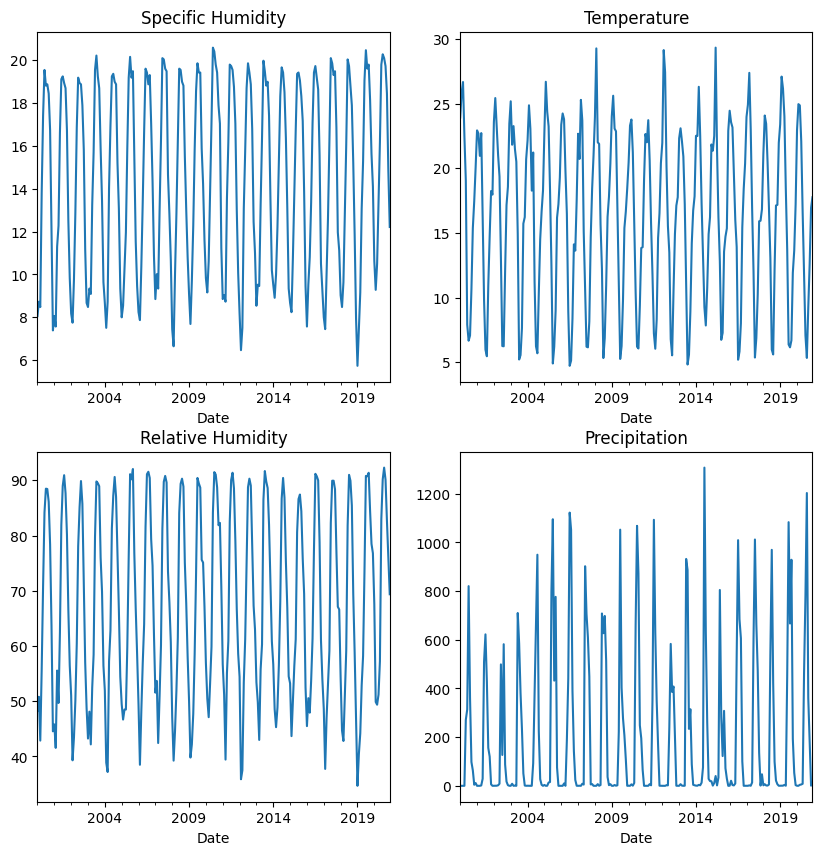

In [103]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

rainfall_data["Specific Humidity"].plot(ax=axes[0, 0], title="Specific Humidity")
rainfall_data["Relative Humidity"].plot(ax=axes[1, 0], title="Relative Humidity")
rainfall_data["Temperature"].plot(ax=axes[0, 1], title="Temperature")
rainfall_data["Precipitation"].plot(ax=axes[1,1], title="Precipitation")

plt.show()

Focusing on the fourth plot, we will decompose this time series using additive method and the `seasonal_decompose` function.

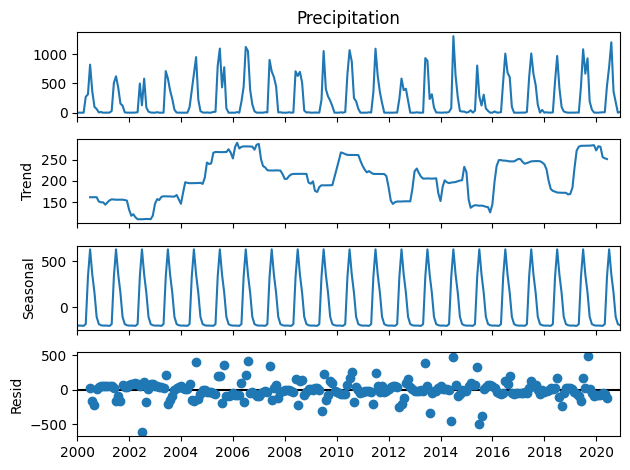

In [104]:
Mumbai = rainfall_data["Precipitation"]
Mumbai.index.freq = 'MS'

seasonal_decompose(Mumbai, model = "additive").plot()
plt.show()